In [5]:
# Install Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Load data - Independent variable
df = pd.read_csv('independent.csv')
df = df.drop(columns=['Series Code'])


# Cleaning independent variable
# From wide to long
df_long = pd.melt(df, id_vars=['Country Name', 'Series Name'],
                  var_name='Year', value_name='amount')

# Convert year to int - need to extract just 4 digits
df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})')
df_long = df_long.dropna(subset=['Year'])
df_long['Year'] = df_long['Year'].astype(int) 

# Renaming columns 
df_long = df_long.rename(columns={'Country Name': 'Country', 'Series Name': 'Variable'})

# Keeping Regulatory Quality variable
df_rq = df_long[df_long['Variable'] == 'Regulatory Quality: Estimate']

# Droping and renaming columns
df_rq = df_rq[['Country', 'Year', 'amount']]
df_rq.columns = ['Country', 'Year', 'regulatory_quality']

print(df_rq.head())

          Country  Year regulatory_quality
0     Afghanistan  2002        -1.81154573
1         Albania  2002       -0.311400771
2         Algeria  2002       -0.574951589
3  American Samoa  2002                 ..
4         Andorra  2002        1.422462821


In [7]:
# Load data - Dependent + control variables
df_con = pd.read_csv('controls.csv')
df_con = df_con.drop(columns=['Series Code'])

# Cleaning Dependent + control variables
# From wide to long
df_con_long = pd.melt(df_con, id_vars=['Country Name', 'Series Name'],
                      var_name='Year', value_name='amount')

# Convert year to int - need to extract just 4 digits
df_con_long['Year'] = df_con_long['Year'].str.extract(r'(\d{4})')
df_con_long = df_con_long.dropna(subset=['Year'])
df_con_long['Year'] = df_con_long['Year'].astype(int)

# Renaming columns
df_con_long = df_con_long.rename(columns={'Country Name': 'Country', 'Series Name': 'Variable'})

# Renaming variables
# Renaming varibales in dictionary 
name_map = {
   'Control of Corruption: Estimate':                                        'control_corruption',

    'Government Effectiveness: Estimate':                                     'government_effectiveness',
    'Rule of Law: Estimate':                                                  'rule_of_law',
    'Voice and Accountability: Estimate':                                     'voice_accountability',
    'CPIA business regulatory environment rating (1=low to 6=high)':          'reg_env_rating',
    'Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990)': 'co2_emissions',
    'Energy imports, net (% of energy use)':                                  'energy_imports_net_pct',
    'Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)':    'energy_use_kg_oil',
    'GDP growth (annual %)':                                                  'gdp_growth',
    'Fossil fuel energy consumption (% of total)':                             'fossil_fuel',
    'Renewable energy consumption (% of total final energy consumption)':      'renewable_energy',
    'Renewable internal freshwater resources, total (billion cubic meters)':   'freshwater_resources',
    'Foreign direct investment, net inflows (BoP, current US$)':               'fdi_inflows'
}

# Replacing names in the dataframe
df_con_long['Variable'] = df_con_long['Variable'].map(name_map).fillna(df_con_long['Variable'])

# Pivot so variables are columns
df_con_wide = df_con_long.pivot(index=['Country', 'Year'], columns='Variable', values='amount').reset_index()

# Reordering columns 

df_con_wide.head()

Variable,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,reg_env_rating,renewable_energy
0,Afghanistan,2002,-67.75374718,..,..,50000000,..,47.15,28.60000117,..,37.8
1,Afghanistan,2003,-65.50544111,..,..,57800000,..,47.15,8.832277803,..,36.7
2,Afghanistan,2004,-69.44425433,..,..,186900000,..,47.15,1.414117993,..,44.2
3,Afghanistan,2005,-56.66621039,..,..,271000000,..,47.15,11.22971483,..,33.9
4,Afghanistan,2006,-51.80685785,..,..,238000000,..,47.15,5.357403247,2.5,31.9


In [8]:
# Merging data

df_merged = pd.merge(df_con_wide, df_rq, on=['Country', 'Year'], how='left')
df_merged.head()

,Country,Year,co2_emissions,energy_imports_net_pct,energy_use_kg_oil,fdi_inflows,fossil_fuel,freshwater_resources,gdp_growth,reg_env_rating,renewable_energy,regulatory_quality
0,Afghanistan,2002,-67.75374718,..,..,50000000,..,47.15,28.60000117,..,37.8,-1.81154573
1,Afghanistan,2003,-65.50544111,..,..,57800000,..,47.15,8.832277803,..,36.7,-1.463107824
2,Afghanistan,2004,-69.44425433,..,..,186900000,..,47.15,1.414117993,..,44.2,-1.511548996
3,Afghanistan,2005,-56.66621039,..,..,271000000,..,47.15,11.22971483,..,33.9,-1.643440247
4,Afghanistan,2006,-51.80685785,..,..,238000000,..,47.15,5.357403247,2.5,31.9,-1.689468622


In [10]:
#Checking for  unbalanced panel
df_merged.replace('..', np.nan, inplace=True)
missing_by_column = df_merged.isnull().mean().sort_values(ascending=False)
print(missing_by_column)

reg_env_rating            0.712082
energy_imports_net_pct    0.425967
energy_use_kg_oil         0.371869
fossil_fuel               0.342617
freshwater_resources      0.271489
renewable_energy          0.140854
fdi_inflows               0.139852
co2_emissions             0.127229
regulatory_quality        0.114406
gdp_growth                0.089160
Country                   0.000000
Year                      0.000000
dtype: float64


In [36]:
# Make a copy to avoid changing the original
df_cleaned = df_merged.copy()

# Convert all object columns (excluding Country) to numeric
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object' and col != 'Country':
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

print(df_cleaned.dtypes)



Country                    object
Year                        int64
co2_emissions             float64
energy_imports_net_pct    float64
energy_use_kg_oil         float64
fdi_inflows               float64
fossil_fuel               float64
freshwater_resources      float64
gdp_growth                float64
reg_env_rating            float64
renewable_energy          float64
regulatory_quality        float64
dtype: object


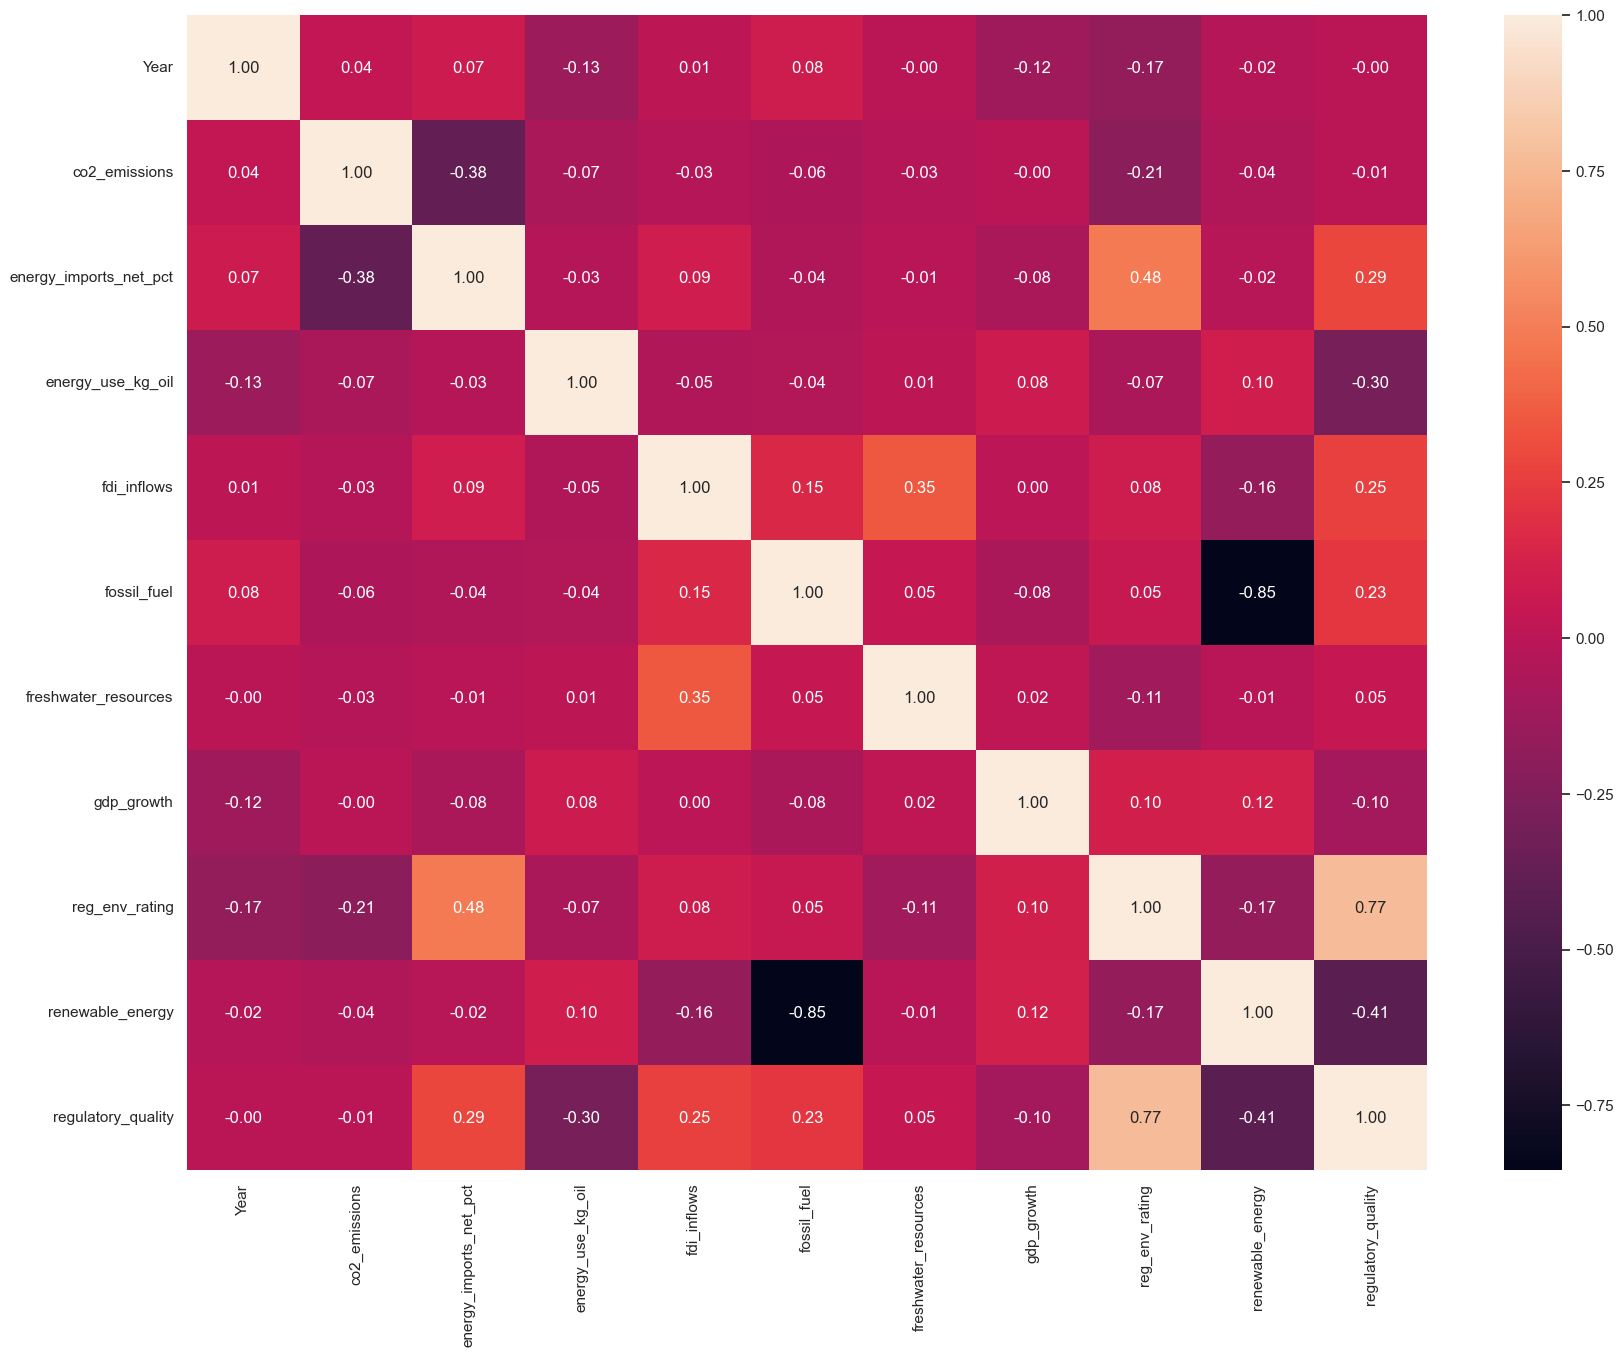

In [ ]:
# Correlation matrix
df_corr = df_cleaned.drop(columns=['Country']).corr()

fig, ax = plt.subplots(1,1,figsize = (20,15))
sns.heatmap(df_corr, annot = True, fmt = '.2f')
plt.show()


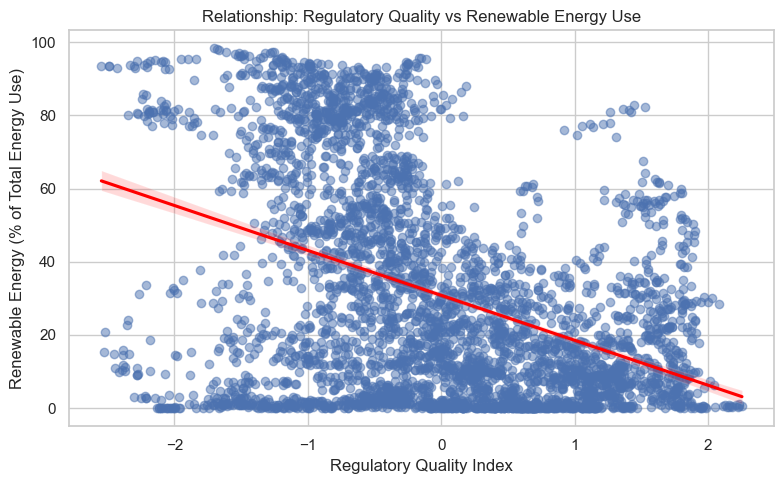

In [39]:
# Independent v/s dependent variable trends graph
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df_cleaned,
    x='regulatory_quality',
    y='renewable_energy',
    scatter_kws={'alpha':0.5},
    line_kws={'color': 'red'}
)
plt.title('Relationship: Regulatory Quality vs Renewable Energy Use')
plt.xlabel('Regulatory Quality Index')
plt.ylabel('Renewable Energy (% of Total Energy Use)')
plt.tight_layout()
plt.show()

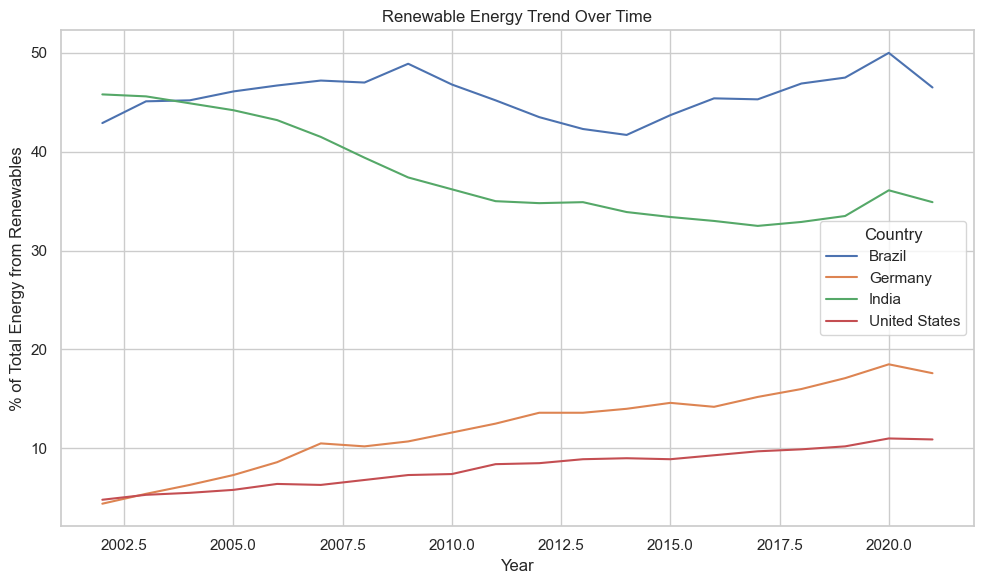

In [41]:
# Choose a few countries to highlight
selected_countries = ['Germany', 'United States', 'India', 'Brazil']

# Filter data
df_selected = df_cleaned[df_cleaned['Country'].isin(selected_countries)]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_selected, x='Year', y='renewable_energy', hue='Country')
plt.title('Renewable Energy Trend Over Time')
plt.ylabel('% of Total Energy from Renewables')
plt.xlabel('Year')
plt.tight_layout()
plt.show()
